In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

In [2]:
## import statcast data
from pybaseball import statcast

In [3]:
data = statcast(start_dt="2023-01-01",end_dt="2023-12-31")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [00:41<00:00,  5.90it/s]
C:\Users\ddund\pybaseball\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [4]:
df = pd.DataFrame(data,
                  columns = ['game_date','player_name',
                             'events', 'game_type',
                             'launch_speed','launch_angle'])
df = df[df['launch_speed'].notna()]
df = df[df['events'].notna()]
df['launch_speed'] = df['launch_speed'].astype(int)
df = df[df['game_type'] == 'R']
df['events'].unique()

array(['field_out', 'single', 'fielders_choice', 'field_error', 'double',
       'grounded_into_double_play', 'home_run', 'force_out',
       'fielders_choice_out', 'sac_fly', 'triple', 'sac_bunt',
       'double_play', 'sac_fly_double_play', 'catcher_interf',
       'triple_play'], dtype=object)

In [5]:
df = df.drop(df[(df['events'] == 'sac_fly') |
             (df['events'] == 'sac_bunt') |
             (df['events'] == 'sac_fly') |
             (df['events'] == 'sac_fly_double_play') |
             (df['events'] == 'catcher_interf')
             ].index)
df['events'].unique()

array(['field_out', 'single', 'double', 'grounded_into_double_play',
       'force_out', 'home_run', 'field_error', 'triple',
       'fielders_choice', 'fielders_choice_out', 'double_play'],
      dtype=object)

In [6]:
# Function to classify hit

def classify_hit(result):
    if result == 'single':
        return 1
    elif result == 'double':
        return 1
    elif result == 'triple':
        return 1
    elif result == 'home_run':
        return 1
    else:
        return 0
    

In [7]:
# Apply function to df
df['hit_out'] = df['events'].apply(classify_hit)
df.head()

,game_date,player_name,events,game_type,launch_speed,launch_angle,hit_out
2432,2023-10-01,"Robertson, Nick",field_out,R,96,-17,0
3824,2023-10-01,"Robertson, Nick",field_out,R,68,46,0
2219,2023-10-01,"Irvin, Cole",field_out,R,62,-64,0
2550,2023-10-01,"Irvin, Cole",field_out,R,80,-38,0
1915,2023-10-01,"Schreiber, John",field_out,R,82,43,0


<Axes: xlabel='launch_speed', ylabel='hit_out'>

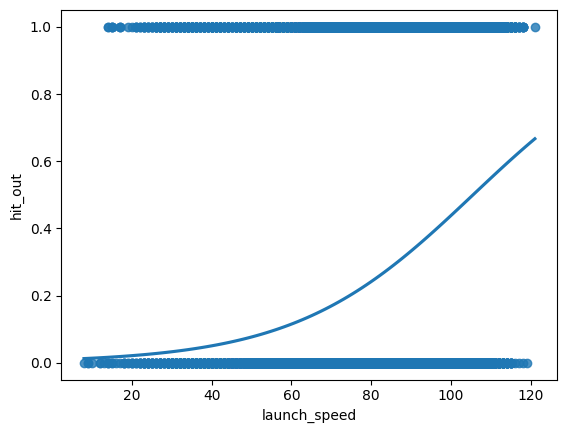

In [8]:
# Plot launch speed to hit or out category
x1 = df['launch_speed']
y = df['hit_out']

sns.regplot(x=x1,y=y, data=df,logistic=True, ci = None)

<Axes: xlabel='launch_angle', ylabel='hit_out'>

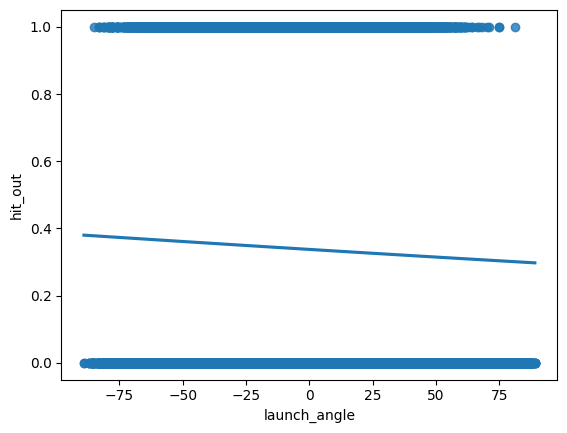

In [9]:
# Plot launch angle to hit or out category
x2 = df['launch_angle']
y = df['hit_out']

sns.regplot(x=x2,y=y, data=df,logistic=True, ci = None)

Neither seems to be good indicators of classifying hits.

In [10]:
# Create metric combining launch speed and angle
df['launch_metric'] = ((df['launch_speed'] + df['launch_angle']) / 2)
df = df[df['launch_metric'].notna()]
df.head()


,game_date,player_name,events,game_type,launch_speed,launch_angle,hit_out,launch_metric
2432,2023-10-01,"Robertson, Nick",field_out,R,96,-17,0,39.5
3824,2023-10-01,"Robertson, Nick",field_out,R,68,46,0,57.0
2219,2023-10-01,"Irvin, Cole",field_out,R,62,-64,0,-1.0
2550,2023-10-01,"Irvin, Cole",field_out,R,80,-38,0,21.0
1915,2023-10-01,"Schreiber, John",field_out,R,82,43,0,62.5


<Axes: xlabel='launch_metric', ylabel='hit_out'>

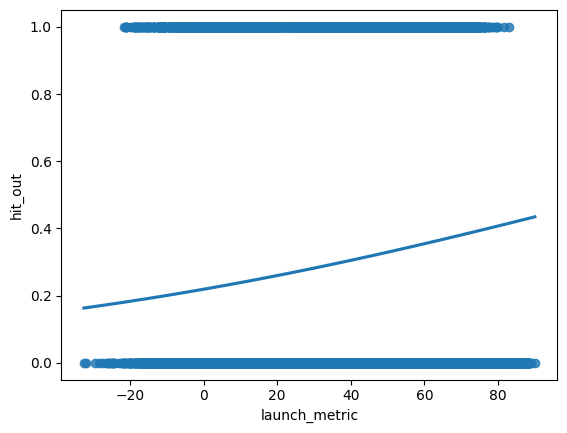

In [11]:
# Plot new launch metric to hit or out category
x3 = df['launch_metric']
y = df['hit_out']

sns.regplot(x=x3,y=y, data=df,logistic=True, ci = None)

Seems there will not be much classification or predictive power

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [13]:
x = df[['launch_metric']]
y= df['hit_out']


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.25, random_state= 24)

In [14]:
model = LogisticRegression()

model.fit(X_train,y_train)

LogisticRegression()

In [15]:
from sklearn import metrics

In [16]:
y_pred = model.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
confusion_matrix

array([[14049,     0],
       [ 7045,     0]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

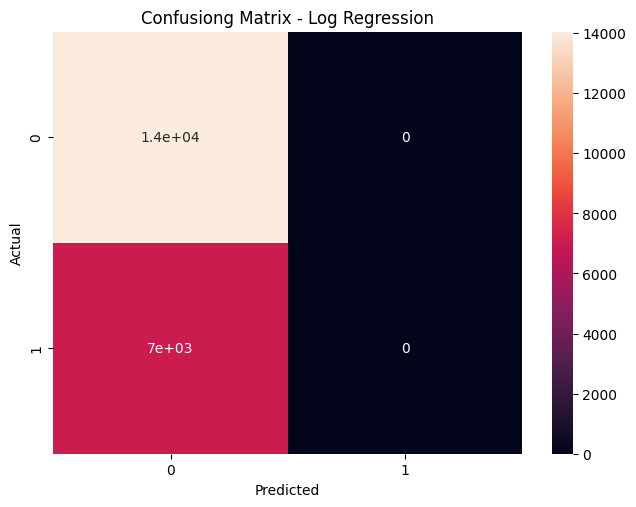

In [18]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(confusion_matrix),annot=True)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusiong Matrix - Log Regression', y = 1.0)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Model predicted no hits in the model, proving that hits come in all speeds and launch angles, giving new meaning to "it looks like a line drive in the scorebook!"